<a href="https://colab.research.google.com/github/AbiyaMakruf/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitTanamanApel/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mendownload dataset
!gdown 1txRjjMdgVyb45G6yqzfGjiGHCb44oOYp

#Melakukan unzip file dataset
!unzip -q Dataset_TugasAkhir.zip

#Menghapus file zip
!rm -rf Dataset_TugasAkhir.zip

#Menghapus file tidak dibutuhkan
!rm -rf sample_data

Downloading...
From (original): https://drive.google.com/uc?id=1txRjjMdgVyb45G6yqzfGjiGHCb44oOYp
From (redirected): https://drive.google.com/uc?id=1txRjjMdgVyb45G6yqzfGjiGHCb44oOYp&confirm=t&uuid=63ce55cd-eadc-4193-b865-927efc42eef0
To: /workspace/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitTanamanApel/Dataset_TugasAkhir.zip
100%|████████████████████████████████████████| 864M/864M [00:14<00:00, 58.4MB/s]


In [1]:
# Import library yang digunakan untuk keseluruhan dataset
import os
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Import model arsitektur dan preprocess input untuk MobileNet dan EfficientNet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, EfficientNetV2B0,EfficientNetV2B1
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess

2024-10-08 07:47:47.226668: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 07:47:47.272555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 07:47:47.272591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 07:47:47.272625: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 07:47:47.282058: I tensorflow/core/platform/cpu_feature_g

In [9]:
# Path ke folder dataset utama
dataset_utama = 'dataset_utama'
dataset_splitted = 'dataset'  # Folder tujuan untuk menyimpan train, validation, test
categories = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Membuat folder train, validation, dan test jika belum ada
for folder in ['train', 'validation', 'test']:
    for category in categories:
        os.makedirs(os.path.join(dataset_splitted, folder, category), exist_ok=True)

# Fungsi untuk membagi file
def split_data(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.8, 0.05, 0.15)):
    files = os.listdir(source_dir)
    files = [f for f in files if os.path.isfile(os.path.join(source_dir, f))]
    random.shuffle(files)

    # Hitung jumlah file untuk setiap split
    train_size = int(split_ratio[0] * len(files))
    val_size = int(split_ratio[1] * len(files))

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    # Pindahkan file ke folder train
    for file in train_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, file))

    # Pindahkan file ke folder validation
    for file in val_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(val_dir, file))

    # Pindahkan file ke folder test
    for file in test_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(test_dir, file))

# Bagi setiap kategori (healthy, multiple_diseases, rust, scab)
for category in categories:
    source_dir = os.path.join(dataset_utama, category)
    train_dir = os.path.join(dataset_splitted, 'train', category)
    val_dir = os.path.join(dataset_splitted, 'validation', category)
    test_dir = os.path.join(dataset_splitted, 'test', category)

    split_data(source_dir, train_dir, val_dir, test_dir)

print("Pembagian dataset selesai.")

Pembagian dataset selesai.


In [2]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator

# Pilih fungsi preprocessing yang sesuai dengan model
preprocess_input_func = efficientnet_preprocess

In [3]:
# Contoh penggunaan untuk EfficientNetB0
base_path = "data/split_train_test_dataset_utama/"

# Pilih fungsi preprocessing yang sesuai dengan model
preprocess_input_func = efficientnet_preprocess

# class_indices = train_generator.class_indices
# print(class_indices)

Epoch 1/20
91/91 [==============================] - 173s 2s/step - loss: 1.0423 - accuracy: 0.5639 - val_loss: 0.6655 - val_accuracy: 0.8389
Epoch 2/20
91/91 [==============================] - 155s 2s/step - loss: 0.7306 - accuracy: 0.7363 - val_loss: 0.4798 - val_accuracy: 0.8778
Epoch 3/20
91/91 [==============================] - 158s 2s/step - loss: 0.6347 - accuracy: 0.7758 - val_loss: 0.4361 - val_accuracy: 0.8667
Epoch 4/20
91/91 [==============================] - 151s 2s/step - loss: 0.5623 - accuracy: 0.8091 - val_loss: 0.3799 - val_accuracy: 0.9111
Epoch 5/20
91/91 [==============================] - 154s 2s/step - loss: 0.5497 - accuracy: 0.8101 - val_loss: 0.3453 - val_accuracy: 0.9000
Epoch 6/20
91/91 [==============================] - 163s 2s/step - loss: 0.5044 - accuracy: 0.8334 - val_loss: 0.3628 - val_accuracy: 0.8833
Epoch 7/20
91/91 [==============================] - 146s 2s/step - loss: 0.4936 - accuracy: 0.8441 - val_loss: 0.3568 - val_accuracy: 0.9000
Epoch 8/20
91

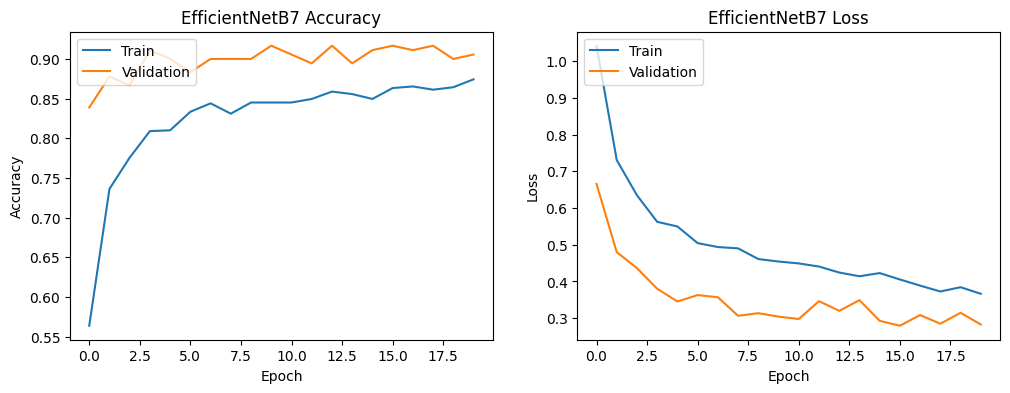

In [9]:
# Fungsi untuk membuat dan meng-compile model dengan perbaikan
def build_and_compile_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    # Tidak perlu preprocessing lagi di sini
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Preprocessing functions
preprocess_funcs = {
    EfficientNetB0: efficientnet_preprocess,
    EfficientNetV2B0: efficientnet_v2_preprocess,
}

# Pilih model dan fungsi preprocessing yang sesuai
preprocess_input_func = efficientnet_preprocess

efficientnet_b7 = build_and_compile_model(EfficientNetB7, input_shape=(600, 600, 3), num_classes=train_generator.num_classes)

# Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fungsi untuk melatih model dan menampilkan grafik
def train_and_plot(model, model_name, train_generator, validation_generator, epochs=20):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        # callbacks=[checkpoint_callback, early_stopping_callback]
    )

    # Plotting hasil
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

train_and_plot(efficientnet_b7, 'EfficientNetB7', train_generator, validation_generator)

Epoch 1/30
91/91 [==============================] - 173s 2s/step - loss: 2.0166 - accuracy: 0.3321 - val_loss: 1.3022 - val_accuracy: 0.4333
Epoch 2/30
91/91 [==============================] - 144s 2s/step - loss: 1.5248 - accuracy: 0.4670 - val_loss: 1.0514 - val_accuracy: 0.5667
Epoch 3/30
91/91 [==============================] - 144s 2s/step - loss: 1.2302 - accuracy: 0.5687 - val_loss: 0.7440 - val_accuracy: 0.7667
Epoch 4/30
91/91 [==============================] - 147s 2s/step - loss: 1.0225 - accuracy: 0.6432 - val_loss: 0.5486 - val_accuracy: 0.8278
Epoch 5/30
91/91 [==============================] - 148s 2s/step - loss: 0.8949 - accuracy: 0.6854 - val_loss: 0.4288 - val_accuracy: 0.8500
Epoch 6/30
91/91 [==============================] - 148s 2s/step - loss: 0.7755 - accuracy: 0.7352 - val_loss: 0.3713 - val_accuracy: 0.8722
Epoch 7/30
91/91 [==============================] - 146s 2s/step - loss: 0.6653 - accuracy: 0.7682 - val_loss: 0.3422 - val_accuracy: 0.8722
Epoch 8/30
91

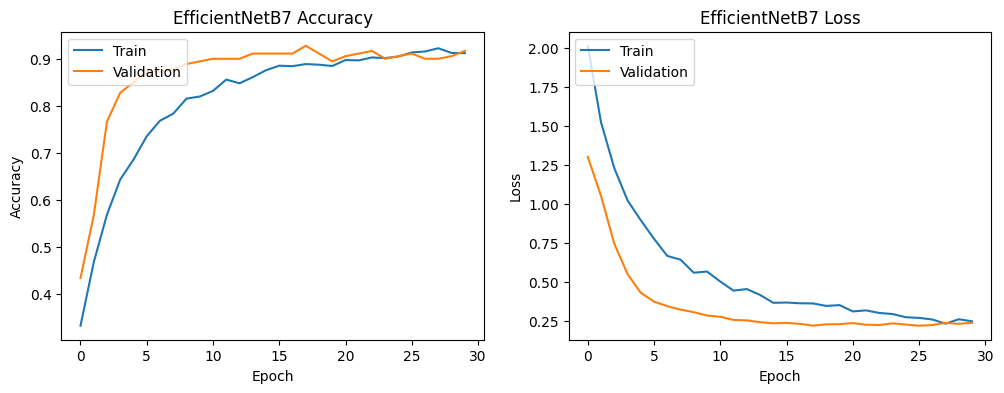

In [11]:
# Fungsi untuk membuat dan meng-compile model dengan perbaikan
def build_and_compile_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    for layer in base_model.layers[:-50]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    # Tidak perlu preprocessing lagi di sini
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Preprocessing functions
preprocess_funcs = {
    EfficientNetB0: efficientnet_preprocess,
    EfficientNetV2B0: efficientnet_v2_preprocess,
}

# Pilih model dan fungsi preprocessing yang sesuai
preprocess_input_func = efficientnet_preprocess

efficientnet_b7 = build_and_compile_model(EfficientNetB7, input_shape=(600, 600, 3), num_classes=train_generator.num_classes)

# Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fungsi untuk melatih model dan menampilkan grafik
def train_and_plot(model, model_name, train_generator, validation_generator, epochs=30):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        # callbacks=[checkpoint_callback, early_stopping_callback]
    )

    # Plotting hasil
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

train_and_plot(efficientnet_b7, 'EfficientNetB7', train_generator, validation_generator)

In [4]:
def build_and_compile_model_not_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_and_compile_model_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze 85% layer pertama dari base model
    total_layers = len(base_model.layers)
    freeze_layers = int(0.85 * total_layers)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
checkpoint_callback = ModelCheckpoint('ENB74CLASS.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [5]:
# Fungsi untuk melatih model dan menampilkan grafik
def train_and_plot(model, model_name, train_generator, validation_generator, epochs=20):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    # Plotting hasil
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    return history

In [ ]:
# EfficientNetB0: 224x224
# EfficientNetB1: 240x240
# EfficientNetB2: 260x260
# EfficientNetB3: 300x300
# EfficientNetB4: 380x380
# EfficientNetB5: 456x456
# EfficientNetB6: 528x528
# EfficientNetB7: 600x600

Found 2912 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 550 images belonging to 4 classes.


2024-09-28 14:54:47.458994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c2:00.0, compute capability: 8.9


Epoch 1/20


2024-09-28 14:54:56.898575: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-28 14:54:57.383835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-09-28 14:54:57.474925: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-28 14:54:58.427255: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9638990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-28 14:54:58.427277: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-09-28 14:54:58.433197: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-28 14:54:58.533732: I ./tensorflow/compiler/jit/device_compiler.

91/91 [==============================] - 54s 507ms/step - loss: 1.0765 - accuracy: 0.5391 - val_loss: 0.6948 - val_accuracy: 0.7389
Epoch 2/20
91/91 [==============================] - 43s 470ms/step - loss: 0.7915 - accuracy: 0.7081 - val_loss: 0.5598 - val_accuracy: 0.8111
Epoch 3/20
91/91 [==============================] - 43s 470ms/step - loss: 0.6797 - accuracy: 0.7630 - val_loss: 0.5798 - val_accuracy: 0.8111
Epoch 4/20
91/91 [==============================] - 43s 468ms/step - loss: 0.6432 - accuracy: 0.7795 - val_loss: 0.5691 - val_accuracy: 0.8000
Epoch 5/20
91/91 [==============================] - 43s 470ms/step - loss: 0.6198 - accuracy: 0.7764 - val_loss: 0.5813 - val_accuracy: 0.8111
Epoch 6/20
91/91 [==============================] - 43s 478ms/step - loss: 0.5998 - accuracy: 0.7905 - val_loss: 0.5719 - val_accuracy: 0.7944
Epoch 7/20
91/91 [==============================] - 42s 466ms/step - loss: 0.5429 - accuracy: 0.8070 - val_loss: 0.5690 - val_accuracy: 0.8056
Epoch 8/20

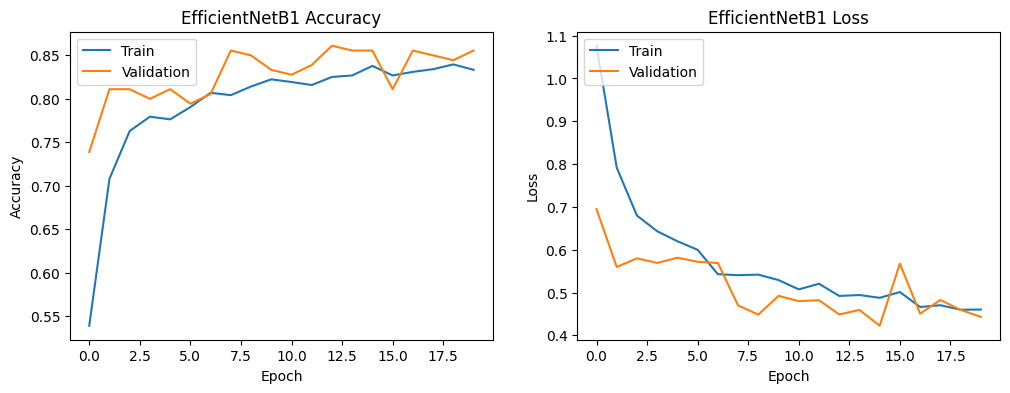

In [5]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(224, 224),
    batch_size=32,
    preprocess_input_func=preprocess_input_func
)

efficientnet_b1 = build_and_compile_model_not_trainable(EfficientNetB1, input_shape=(224, 224, 3), num_classes=train_generator.num_classes)
train_and_plot(efficientnet_b1, 'EfficientNetB1', train_generator, validation_generator, epochs = 20)

Found 2912 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 550 images belonging to 4 classes.
Epoch 1/20
91/91 [==============================] - 64s 570ms/step - loss: 2.4292 - accuracy: 0.2668 - val_loss: 1.3127 - val_accuracy: 0.3222
Epoch 2/20
91/91 [==============================] - 46s 509ms/step - loss: 2.2232 - accuracy: 0.3046 - val_loss: 1.2135 - val_accuracy: 0.3778
Epoch 3/20
91/91 [==============================] - 43s 478ms/step - loss: 2.0475 - accuracy: 0.3314 - val_loss: 1.0522 - val_accuracy: 0.5000
Epoch 4/20
91/91 [==============================] - 42s 464ms/step - loss: 1.9212 - accuracy: 0.3671 - val_loss: 0.9127 - val_accuracy: 0.6389
Epoch 5/20
91/91 [==============================] - 44s 478ms/step - loss: 1.7209 - accuracy: 0.4159 - val_loss: 0.8290 - val_accuracy: 0.6778
Epoch 6/20
91/91 [==============================] - 42s 462ms/step - loss: 1.6426 - accuracy: 0.4478 - val_loss: 0.7858 - val_accuracy: 0.7056
Epoch 7/20
91/91 [

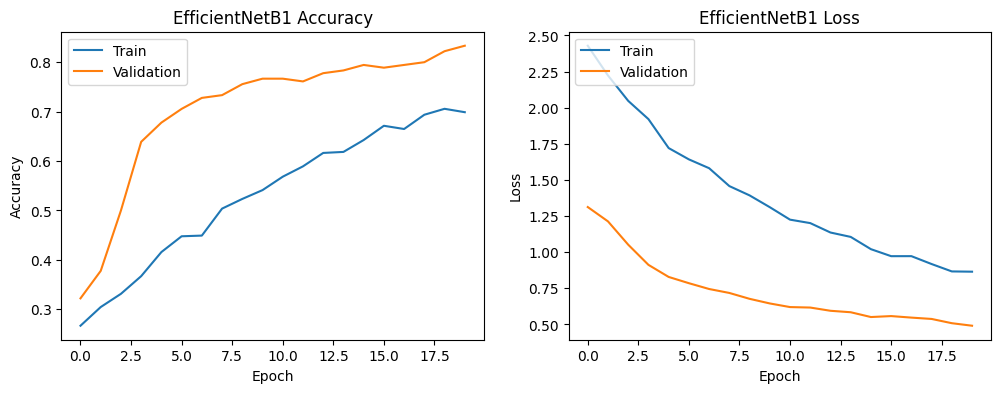

In [6]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(224, 224),
    batch_size=32,
    preprocess_input_func=preprocess_input_func
)

efficientnet_b1 = build_and_compile_model_trainable(EfficientNetB1, input_shape=(224, 224, 3), num_classes=train_generator.num_classes)
train_and_plot(efficientnet_b1, 'EfficientNetB1', train_generator, validation_generator, epochs = 20)

Found 2912 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 550 images belonging to 4 classes.
28456008/28456008 [==============================] - 0s 0us/step
Epoch 1/25
91/91 [==============================] - 53s 515ms/step - loss: 1.1224 - accuracy: 0.5175 - val_loss: 0.8285 - val_accuracy: 0.6556
Epoch 2/25
91/91 [==============================] - 47s 512ms/step - loss: 0.8237 - accuracy: 0.7005 - val_loss: 0.8346 - val_accuracy: 0.6889
Epoch 3/25
91/91 [==============================] - 47s 519ms/step - loss: 0.7049 - accuracy: 0.7521 - val_loss: 0.8215 - val_accuracy: 0.7056
Epoch 4/25
91/91 [==============================] - 45s 500ms/step - loss: 0.6454 - accuracy: 0.7795 - val_loss: 0.5815 - val_accuracy: 0.8000
Epoch 5/25
91/91 [==============================] - 47s 518ms/step - loss: 0.6251 - accuracy: 0.7898 - val_loss: 0.4794 - val_accuracy: 0.8444
Epoch 6/25
91/91 [==============================] - 47s 516ms/step - loss: 0.5985 - accuracy: 0.

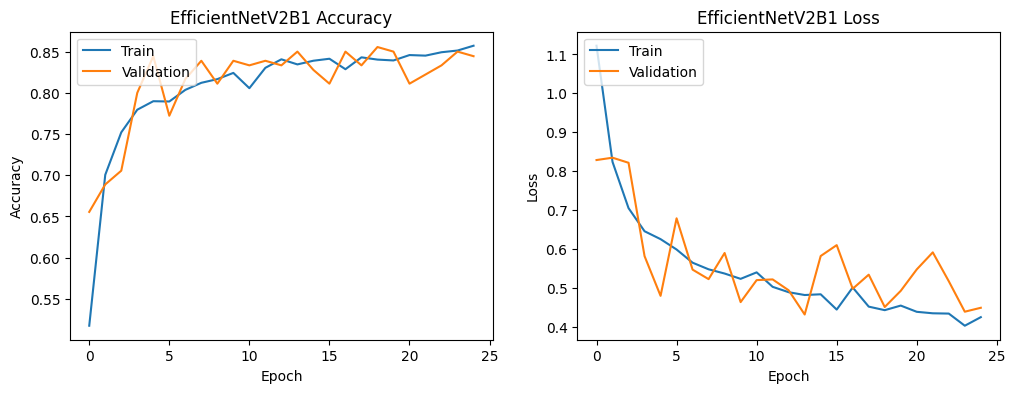

In [15]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(240 , 240 ),
    batch_size=32,
    preprocess_input_func=preprocess_input_func
)

efficientnet_v2b1 = build_and_compile_model_not_trainable(EfficientNetV2B1, input_shape=(240 , 240 , 3), num_classes=train_generator.num_classes)
train_and_plot(efficientnet_v2b1, 'EfficientNetV2B1', train_generator, validation_generator, epochs = 25)

Found 2912 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 550 images belonging to 4 classes.
Epoch 1/25
91/91 [==============================] - 45s 494ms/step - loss: 0.4088 - accuracy: 0.8578 - val_loss: 0.4687 - val_accuracy: 0.8389
Epoch 2/25
91/91 [==============================] - 45s 499ms/step - loss: 0.4162 - accuracy: 0.8530 - val_loss: 0.5820 - val_accuracy: 0.8278
Epoch 3/25
91/91 [==============================] - 45s 498ms/step - loss: 0.4233 - accuracy: 0.8547 - val_loss: 0.5547 - val_accuracy: 0.8222
Epoch 4/25
91/91 [==============================] - 46s 506ms/step - loss: 0.4245 - accuracy: 0.8475 - val_loss: 0.4821 - val_accuracy: 0.8444
Epoch 5/25
91/91 [==============================] - 45s 500ms/step - loss: 0.4217 - accuracy: 0.8523 - val_loss: 0.4915 - val_accuracy: 0.8278
Epoch 6/25
91/91 [==============================] - 45s 495ms/step - loss: 0.3853 - accuracy: 0.8712 - val_loss: 0.4730 - val_accuracy: 0.8389
Epoch 7/25
91/91 [

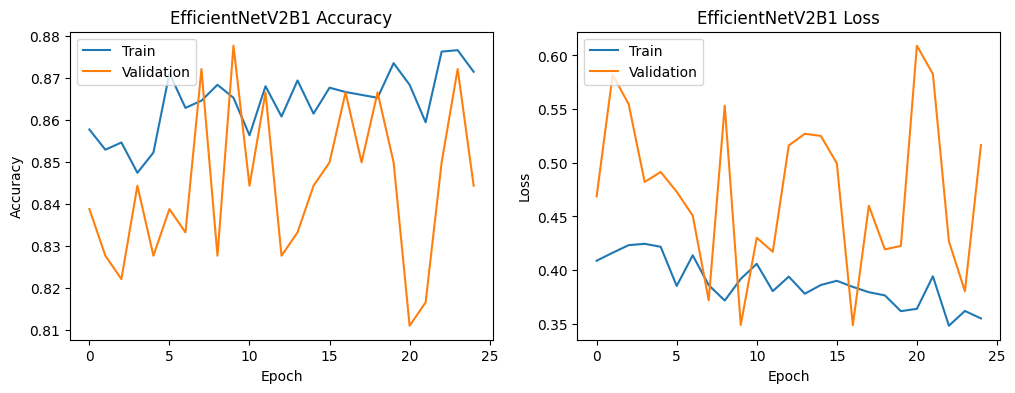

In [16]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(240, 240),
    batch_size=32,
    preprocess_input_func=preprocess_input_func
)

efficientnet_b1 = build_and_compile_model_trainable(EfficientNetV2B1, input_shape=(240, 240, 3), num_classes=train_generator.num_classes)
train_and_plot(efficientnet_v2b1, 'EfficientNetV2B1', train_generator, validation_generator, epochs = 25)

In [17]:
from tensorflow.keras.applications import EfficientNetV2B3

Found 2912 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 550 images belonging to 4 classes.
52606240/52606240 [==============================] - 1s 0us/step
Epoch 1/5
91/91 [==============================] - 71s 706ms/step - loss: 1.0676 - accuracy: 0.5484 - val_loss: 0.7396 - val_accuracy: 0.6944
Epoch 2/5
91/91 [==============================] - 62s 683ms/step - loss: 0.7529 - accuracy: 0.7280 - val_loss: 0.7267 - val_accuracy: 0.7056
Epoch 3/5
91/91 [==============================] - 63s 691ms/step - loss: 0.6534 - accuracy: 0.7819 - val_loss: 0.4817 - val_accuracy: 0.8167
Epoch 4/5
91/91 [==============================] - 62s 682ms/step - loss: 0.5819 - accuracy: 0.8091 - val_loss: 0.4907 - val_accuracy: 0.8111
Epoch 5/5
91/91 [==============================] - 63s 692ms/step - loss: 0.5608 - accuracy: 0.8046 - val_loss: 0.4243 - val_accuracy: 0.8389


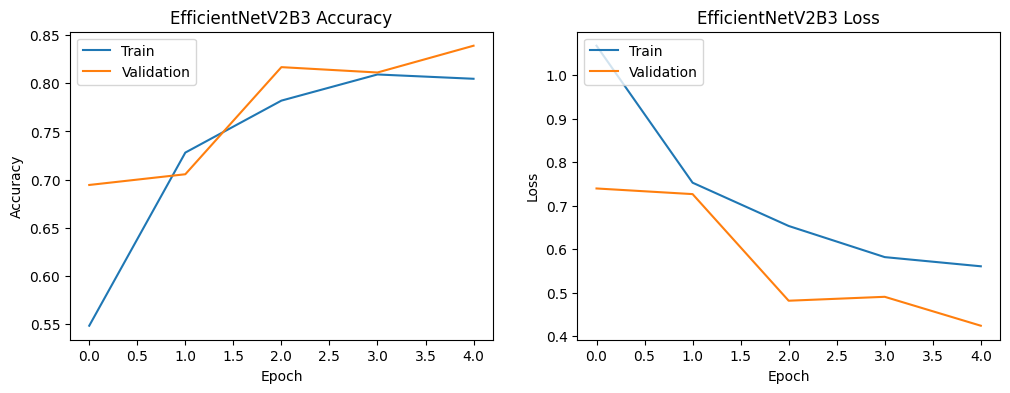

In [18]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(300 , 300),
    batch_size=32,
    preprocess_input_func=preprocess_input_func
)

efficientnet_v2b3 = build_and_compile_model_not_trainable(EfficientNetV2B3, input_shape=(300 , 300 , 3), num_classes=train_generator.num_classes)
train_and_plot(efficientnet_v2b3, 'EfficientNetV2B3', train_generator, validation_generator, epochs = 5)

Found 2912 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 550 images belonging to 4 classes.
Epoch 1/15
91/91 [==============================] - 74s 689ms/step - loss: 2.3257 - accuracy: 0.2788 - val_loss: 1.3948 - val_accuracy: 0.2167
Epoch 2/15
91/91 [==============================] - 64s 700ms/step - loss: 2.0274 - accuracy: 0.3389 - val_loss: 1.2520 - val_accuracy: 0.3889
Epoch 3/15
91/91 [==============================] - 61s 675ms/step - loss: 1.7952 - accuracy: 0.3949 - val_loss: 1.0861 - val_accuracy: 0.5389
Epoch 4/15
91/91 [==============================] - 62s 684ms/step - loss: 1.6790 - accuracy: 0.4282 - val_loss: 0.9485 - val_accuracy: 0.6222
Epoch 5/15
91/91 [==============================] - 62s 684ms/step - loss: 1.5154 - accuracy: 0.4815 - val_loss: 0.8659 - val_accuracy: 0.6944
Epoch 6/15
91/91 [==============================] - 63s 688ms/step - loss: 1.4262 - accuracy: 0.4979 - val_loss: 0.8185 - val_accuracy: 0.7222
Epoch 7/15
91/91 [

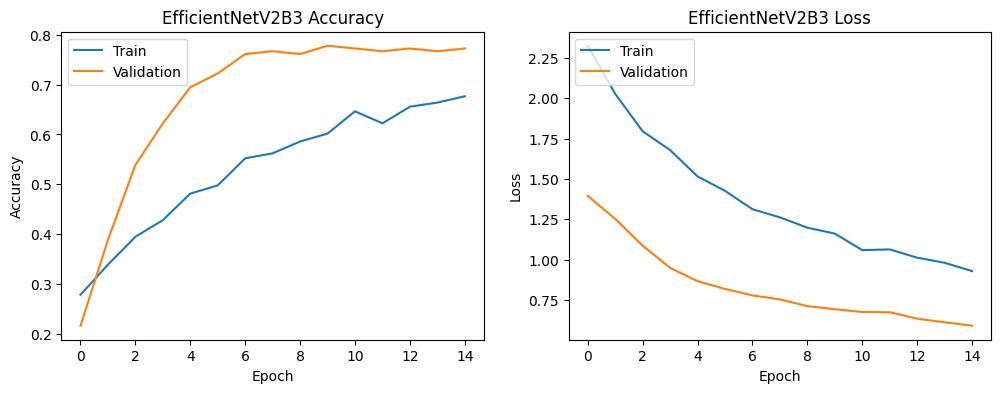

In [20]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(300, 300),
    batch_size=32,
    preprocess_input_func=preprocess_input_func
)

efficientnet_v2b3 = build_and_compile_model_trainable(EfficientNetV2B3, input_shape=(300, 300, 3), num_classes=train_generator.num_classes)
train_and_plot(efficientnet_v2b3, 'EfficientNetV2B3', train_generator, validation_generator, epochs = 15)

Found 1273 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
Found 275 images belonging to 4 classes.


2024-10-01 16:05:47.296783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:82:00.0, compute capability: 8.9


Epoch 1/20


2024-10-01 16:06:10.703426: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-01 16:06:11.827204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-10-01 16:06:11.950515: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-01 16:06:14.638533: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7c7ba829fd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-01 16:06:14.638558: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-01 16:06:14.642401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 16:06:14.739824: I ./tensorflow/compiler/jit/device_comp

80/80 [==============================] - 128s 1s/step - loss: 1.6052 - accuracy: 0.3983 - val_loss: 1.1574 - val_accuracy: 0.5092
Epoch 2/20
80/80 [==============================] - 102s 1s/step - loss: 1.0773 - accuracy: 0.5829 - val_loss: 0.9933 - val_accuracy: 0.5641
Epoch 3/20
80/80 [==============================] - 89s 1s/step - loss: 0.7766 - accuracy: 0.7148 - val_loss: 0.7395 - val_accuracy: 0.7179
Epoch 4/20
80/80 [==============================] - 114s 1s/step - loss: 0.6322 - accuracy: 0.7761 - val_loss: 0.5516 - val_accuracy: 0.8352
Epoch 5/20
80/80 [==============================] - 102s 1s/step - loss: 0.5624 - accuracy: 0.8036 - val_loss: 0.4216 - val_accuracy: 0.8791
Epoch 6/20
80/80 [==============================] - 88s 1s/step - loss: 0.4551 - accuracy: 0.8405 - val_loss: 0.3601 - val_accuracy: 0.8901
Epoch 7/20
80/80 [==============================] - 84s 1s/step - loss: 0.4168 - accuracy: 0.8610 - val_loss: 0.3199 - val_accuracy: 0.8864
Epoch 8/20
80/80 [=========

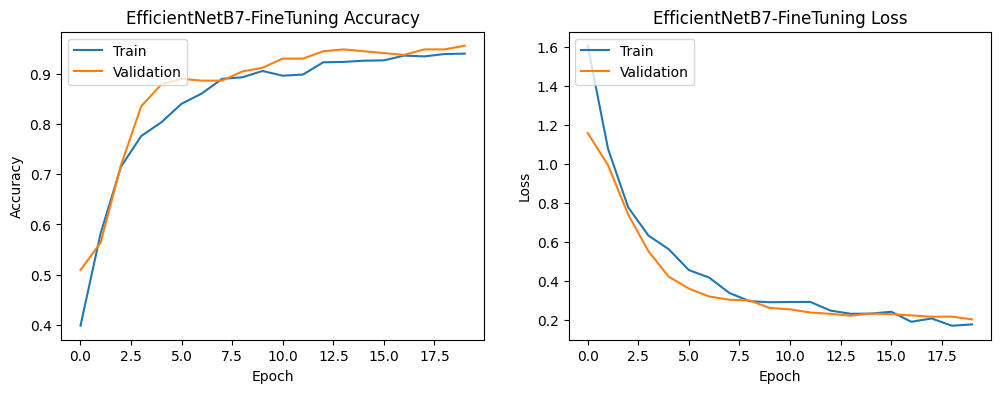

In [6]:
base_path = "data/split_train_test_dataset_utama"
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(600, 600),
    batch_size=16,
    preprocess_input_func= efficientnet_preprocess
)

efficientnet_b7 = build_and_compile_model_trainable(EfficientNetB7, input_shape=(600, 600, 3), num_classes=train_generator.num_classes)
train_and_plot(efficientnet_b7, 'EfficientNetB7-FineTuning', train_generator, validation_generator, epochs = 20)

Found 1273 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
Found 275 images belonging to 4 classes.
Epoch 1/50
80/80 [==============================] - 135s 1s/step - loss: 1.6132 - accuracy: 0.3896 - val_loss: 1.3426 - val_accuracy: 0.3407
Epoch 2/50
80/80 [==============================] - 93s 1s/step - loss: 1.0341 - accuracy: 0.5915 - val_loss: 1.2508 - val_accuracy: 0.3407
Epoch 3/50
80/80 [==============================] - 86s 1s/step - loss: 0.7538 - accuracy: 0.7141 - val_loss: 1.0432 - val_accuracy: 0.4689
Epoch 4/50
80/80 [==============================] - 87s 1s/step - loss: 0.5705 - accuracy: 0.7934 - val_loss: 0.7583 - val_accuracy: 0.7106
Epoch 5/50
80/80 [==============================] - 81s 1s/step - loss: 0.4734 - accuracy: 0.8335 - val_loss: 0.5203 - val_accuracy: 0.8059
Epoch 6/50
80/80 [==============================] - 77s 962ms/step - loss: 0.4100 - accuracy: 0.8625 - val_loss: 0.3711 - val_accuracy: 0.8755
Epoch 7/50
80/80 [==============

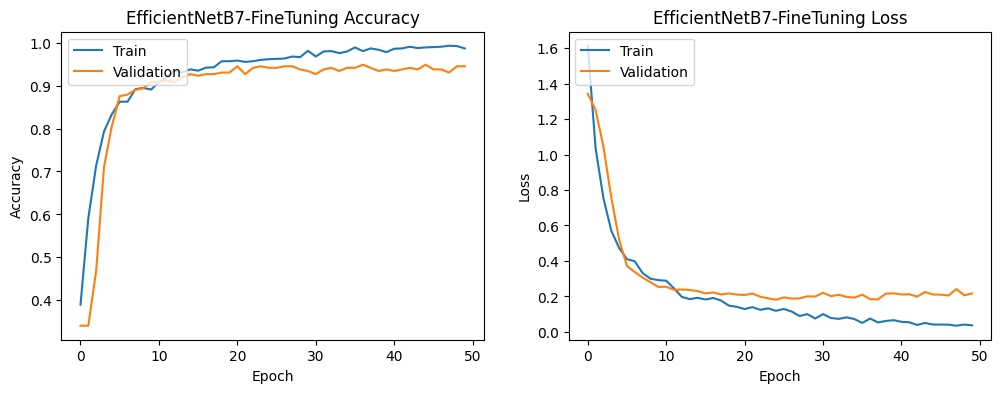

In [8]:
base_path = "data/split_train_test_dataset_utama"
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(600, 600),
    batch_size=16,
    preprocess_input_func= efficientnet_preprocess
)

efficientnet_b7 = build_and_compile_model_trainable(EfficientNetB7, input_shape=(600, 600, 3), num_classes=train_generator.num_classes)
train_and_plot(efficientnet_b7, 'EfficientNetB7-FineTuning', train_generator, validation_generator, epochs = 50)

Found 1273 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
Found 275 images belonging to 4 classes.


2024-10-08 07:48:11.036547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:53:00.0, compute capability: 8.6


Epoch 1/50


2024-10-08 07:48:37.978421: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-08 07:48:39.154987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-10-08 07:48:39.261148: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-08 07:48:43.010696: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xfa663e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-08 07:48:43.010726: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-10-08 07:48:43.016867: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-08 07:48:43.123757: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

80/80 [==============================] - ETA: 0s - loss: 1.6521 - accuracy: 0.3786

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 139s 1s/step - loss: 1.6521 - accuracy: 0.3786 - val_loss: 1.1602 - val_accuracy: 0.5495
Epoch 2/50
80/80 [==============================] - 103s 1s/step - loss: 1.0954 - accuracy: 0.5844 - val_loss: 0.9211 - val_accuracy: 0.6996
Epoch 3/50
80/80 [==============================] - 104s 1s/step - loss: 0.7865 - accuracy: 0.7203 - val_loss: 0.6918 - val_accuracy: 0.8132
Epoch 4/50
80/80 [==============================] - 103s 1s/step - loss: 0.5969 - accuracy: 0.7808 - val_loss: 0.5240 - val_accuracy: 0.8278
Epoch 5/50
80/80 [==============================] - 95s 1s/step - loss: 0.5357 - accuracy: 0.8020 - val_loss: 0.4269 - val_accuracy: 0.8571
Epoch 6/50
80/80 [==============================] - 105s 1s/step - loss: 0.4295 - accuracy: 0.8421 - val_loss: 0.3780 - val_accuracy: 0.8718
Epoch 7/50
80/80 [==============================] - 98s 1s/step - loss: 0.3396 - accuracy: 0.8916 - val_loss: 0.3456 - val_accuracy: 0.8901
Epoch 8/50
80/80 [========

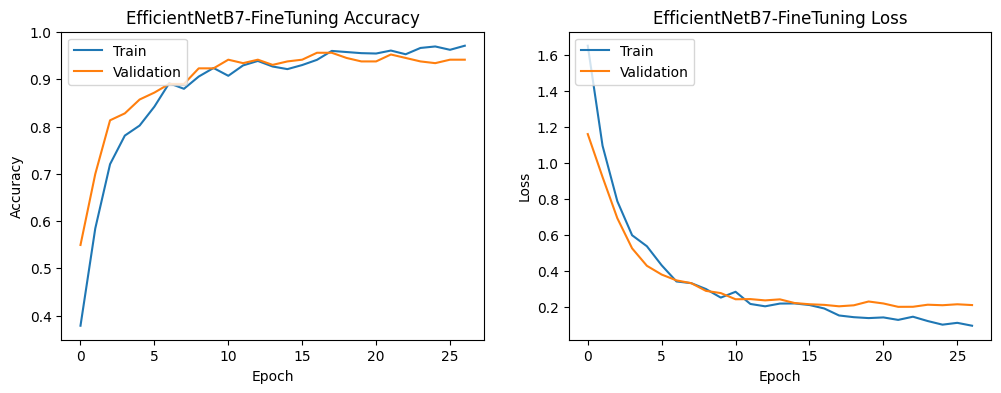

In [6]:
base_path = "data/split_train_test_dataset_utama/"
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(600, 600),
    batch_size=16,
    preprocess_input_func= efficientnet_preprocess
)

efficientnet_b7 = build_and_compile_model_trainable(EfficientNetB7, input_shape=(600, 600, 3), num_classes=train_generator.num_classes)
history = train_and_plot(efficientnet_b7, 'EfficientNetB7-FineTuning', train_generator, validation_generator, epochs = 50)